# Experiment 1: Raw LIDAR scan to HD Map registration

In [ ]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook


<IPython.core.display.Javascript object>


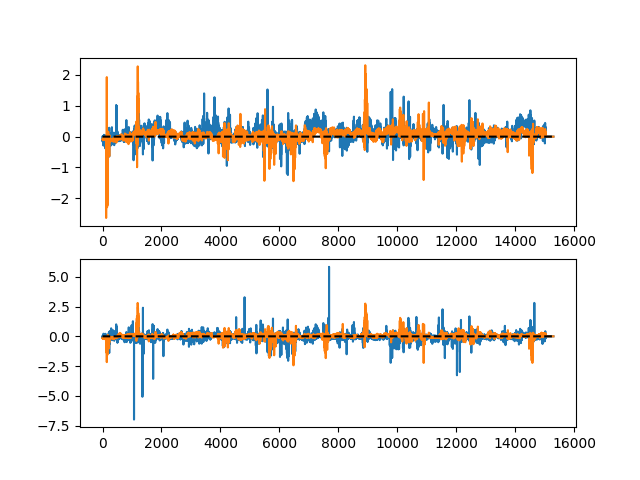

In [34]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

VICET = np.load('results/VICET/tempVICET.npy')
NDT = np.load('results/ICET/tempICET.npy')


fig, ax = plt.subplots(2,1)
ax[0].plot(VICET[:,0], color = "C0")
# ax[0].plot(VICET[:,6], color = "C0", ls = '--',alpha = 0.3)
# ax[0].plot(VICET[:,0] + VICET[:,6], color = "C2")
ax[0].plot(NDT[:,0], color = "C1")
ax[0].plot(np.zeros(len(NDT)), color = 'k', ls = '--')

ax[1].plot(VICET[:,1])
# ax[1].plot(VICET[:,7], color = "C0", ls = '--',alpha = 0.3)
ax[1].plot(NDT[:,1])
ax[1].plot(np.zeros(len(NDT)), color = 'k', ls = '--')

In [37]:
RMSE_VICET = np.sqrt(np.mean(VICET**2, axis=0))
print("RMSE VICET:", RMSE_VICET[:6])
RMSE_NDT = np.sqrt(np.mean(NDT**2, axis=0))
print("RMSE NDT:  ", RMSE_NDT)

RMSE VICET: [0.18432894 0.21937484 0.0890445  0.02085324 0.01842996 0.03838419]
RMSE NDT:   [0.189594   0.22631694 0.05078814 0.0064669  0.00648836 0.01502088]


In [ ]:
#load HD Map
pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

In [ ]:
#load ground truth
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D4/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

# it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#                draw = False, group = 2, RM = False, DNN_filter = False)
it = ICET(cloud1 = submap, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False)

In [ ]:
#put HD Map and new scan in frame of raw keyframe scan
# idx = 2700 #2750 
idx = 1800 #test
skip = 25 #10 #how many lidar frames between keyframe and new scan
offset = 10 #works best for 05 dataset
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D4/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform everything to pc1 frame
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

# #remove 4th column and center first scan about origin
# scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
# scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
# submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

#remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
pc1_too_close = tf.where(pc1_spherical[:,0] < 2. )[:,0]
pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
print(len(pc1_too_close))
pc1 = pc1[pc1_not_too_close.numpy()]
# disp.append(Points(pc1[pc1_too_close.numpy()], c = 'black', r = 5)) #red

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

plt.show(disp, "05 Quad With Dynamics Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
#test ICP registration on a single pair of frames
# icp_rigid_transform, _, _ = trimesh.registration.icp(pc1, pc2_in_pc1_frame) #scan to scan
icp_rigid_transform, transformed_pc1, cost = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=150) #scan to HD Map
icp_trans = icp_rigid_transform[:3,3]
icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
print(icp_trans, icp_euls)
print(cost)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

alph = 0.4
disp.append(Points(pc1, c = 'red', r =3, alpha = alph))
disp.append(Points(transformed_pc1, c = 'blue', r =3, alpha = alph))
# disp.append(Points(submap_in_pc1_frame, c = 'grey', r = 3, alpha = alph))
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314

plt.show(disp, "ICP Test")
ViewInteractiveWidget(plt.window)

### Run VICET, NDT, and  ICP for 200 frames of Newer College "05: Quad With Dynamics"


In [ ]:
from linear_corrector import LC #VICET
st = time.time()

runlen = 200
# start_idx = 2700
start_idx = 1700 #test

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_stds = np.zeros([runlen,12])
X_hist = np.zeros([runlen, 6]) #ICET/ NDT
X_hist_ICP = np.zeros([runlen, 6]) #ICP
raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #9 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]

    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run ICP ------------------------------------------------------------
#     icp_rigid_transform, _, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame) #scan to HD Map
    init = np.array([[1, 0, 0, 0.01*np.random.randn()],
                     [0.,1, 0, 0.01*np.random.randn()],
                     [0, 0, 1, 0.01*np.random.randn()],
                     [0, 0, 0, 1]])
    icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, initial = init,
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
    icp_trans = icp_rigid_transform[:3,3]
    icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
    X_hist_ICP[idx,:] = np.append(icp_trans, icp_euls) 
    print(icp_trans, icp_euls)

#     np.save("results/ICP/ICP_05_start_from_1700_v1", X_hist_ICP)
    
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    
    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
        fid = 55, niter = 50, draw = False, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)
    A_hist[idx,:] = dc.A
    VICET_pred_stds[idx,:] = dc.pred_stds
#     np.save("results/VICET/VICET_05_start_from_1700_v1", A_hist)
#     np.save("results/VICET/VICET_pred_stds_05_start_from_1700_v1", VICET_pred_stds)        

#     #run ICET ------------------------------------------------------------
    initial_guess = tf.constant([0.01*np.random.randn(),0.01*np.random.randn(),0.,0.,0.,0.])
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
    X_hist[idx,:] = it.X

#     np.save("results/ICET/ICET_05_start_from_1700_v1", X_hist)
    
    # Calculate CD for raw, ICET, VICET --------------------------
    
#     #only consdier LIDAR points within convex hull of HD Map + some buffer
#     hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
#     subsample = 10
# #     OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
# #     OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
# #     source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
#     VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
#     VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
#     source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
#     ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
#     ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
#     source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
#     ICP_in_hull = transformed_pc1[::subsample,:] 
#     ICP_in_hull = ICP_in_hull[np.where( in_hull(ICP_in_hull, hull) )]
#     source_cloud_ICP = torch.from_numpy(ICP_in_hull)[None,:,:].float()     

#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
#     #need to downsample to keep runtime down
#     every_nth = 10
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
# #     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
# #     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

# #     dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
# #     print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
#     dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
#     print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
#     dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
#     print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())
#     dist_forward_ICP = chamferDist(source_cloud_ICP, target_cloud)
#     print("Chamfer Distance after ICP: \n:", dist_forward_ICP.detach().cpu().item())

# #     print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
#     print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
#     print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
#     print("\n Normalized ICP CD: \n", dist_forward_ICP/len(transformed_pc1))    
    
# #     raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
#     rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
#     VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
#     ICP_CD_hist[idx] = dist_forward_ICP/len(transformed_pc1)


In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v2.txt")
VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v2.txt")
rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v2.txt")
ax.plot(VICET_CD_hist)
ax.plot(rigid_ICET_CD_hist)
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")

# ax.plot(rigid_ICET_CD_hist, label="NDT")
# ax.plot(VICET_CD_hist, label = "VICET")
# ax.plot(ICP_CD_hist, label="ICP")
# ax.legend(loc='best')

In [ ]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [ ]:
fig, ax = plt.subplots()
# ax.plot(np.diff(poses[2700:2900,0,3])) #forward aligned velocity
ax.plot(np.diff(np.sqrt(poses[2700:2900,0,3]**2  + poses[2700:2900,1,3]**2))) #absolute frame-to-frame motion in xy plane

# ax.plot(X_hist_ICP)

# Plot 200 frames of ICP, VICET, and NDT over HD Map 

In [ ]:
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]
ptsize = 7
alph = 0.5
start_idx = 2700 
end_idx = start_idx + 200
# disp.append(Points(LOAM_traj[:,:3], alpha = 0.2)) #draw raw  LOAM data
# start_point = Points([[0.,0,0]], c='red', r =15).legend("Start Position")
# disp.append(start_point)

#draw GT trajectory
#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
# gt_lidarframe = (poses[start_idx] @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
#rotate 180 deg about vertical axis to align with LOAM results
gt_lidarframe[:,:3] = gt_lidarframe[:,:3] @ R.from_euler('xyz', [np.deg2rad(0), np.deg2rad(10.25), np.deg2rad(75.5)]).as_matrix() #test
# gt_points = Points(gt_lidarframe[2000:3000,:3], c = "black", r=3).legend("Actual Motion of Platform")
gt_points = Line(gt_lidarframe[2700:2900,:3], c = "red", lw = 4, alpha = 1).legend("Actual Motion of Platform")
disp.append(gt_points)

#draw HD Map -------------------------------------------
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# submap_mapframe = (poses[start_idx] @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
rot_mat = R.from_euler('xyz', [0, 0, np.deg2rad(195)]).as_matrix()
submap_lidarframe = submap_lidarframe @ rot_mat
# disp.append(Points(submap_lidarframe, c = "black", r = 1, alpha = 0.2)) #full map
disp.append(Points(submap_lidarframe[submap_lidarframe[:,0] < 3], c = "black", r = 2, alpha = 0.05)) #cut map for figure
# disp.append(Points(submap_lidarframe[submap_lidarframe[:,1] < 18], c = "black", r = 2, alpha = 0.1)) #cut map for figure

#draw VICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
start_idx_VICET = 2700 #2700
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_2700_v5.npy")
# VICET_A_hist = np.load("results/VICET/VICET_05_start_from_2850.npy")

VICET_A_hist_v1 = np.load("results/VICET/VICET_05_start_from_2700.npy")
VICET_A_hist_v2 = np.load("results/VICET/VICET_05_start_from_2700_v2.npy")
VICET_A_hist_v3 = np.load("results/VICET/VICET_05_start_from_2700_v3.npy")
VICET_A_hist_v4 = np.load("results/VICET/VICET_05_start_from_2700_v4.npy")
VICET_A_hist_v5 = np.load("results/VICET/VICET_05_start_from_2700_v5.npy")
A_hist_all = np.array([VICET_A_hist_v1, VICET_A_hist_v2, VICET_A_hist_v3, VICET_A_hist_v4, VICET_A_hist_v5])
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
VICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]

# VICET_A_hist = np.array([VICET_A_hist[:,0], VICET_A_hist[:,2],  VICET_A_hist[:,1], VICET_A_hist[:,3], VICET_A_hist[:,4], VICET_A_hist[:,5]]).T

# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + 
#               VICET_A_hist[:,:3] + VICET_A_hist[:,6:9])
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])
# VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3])

#line up at start
VICET_traj -= VICET_traj[0,:]
#rotate to align with gt
VICET_traj = VICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

VICET_points = Points(VICET_traj[:,:3], c='blue', r=ptsize, alpha = alph).legend("VICET")
# VICET_points = Line(VICET_traj[:,:3], lw = 3, c='blue', alpha = 1).legend("VICET")
# disp.append(VICET_points)

#draw ICET trajectory~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_static_A_hist.npy")
# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_static_A_hist_v2.npy") #run again 7/11, fid = 40

# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_2700_v5.npy") #200 frames only
# ICET_A_hist = np.load("results/ICET/ICET_05_start_from_2850.npy") #100 frames only

ICET_A_hist_v1 = np.load("results/ICET/ICET_05_start_from_2700.npy")
ICET_A_hist_v2 = np.load("results/ICET/ICET_05_start_from_2700_v2.npy")
ICET_A_hist_v3 = np.load("results/ICET/ICET_05_start_from_2700_v3.npy")
ICET_A_hist_v4 = np.load("results/ICET/ICET_05_start_from_2700_v4.npy")
ICET_A_hist_v5 = np.load("results/ICET/ICET_05_start_from_2700_v5.npy")
A_hist_all = np.array([ICET_A_hist_v1, ICET_A_hist_v2, ICET_A_hist_v3, ICET_A_hist_v4,  ICET_A_hist_v5])
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
ICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
ICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + ICET_A_hist[:,:3])

#line up at start
ICET_traj -= ICET_traj[0,:]
#rotate to align with gt
ICET_traj = ICET_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

ICET_points = Points(ICET_traj[:,:3], c='orange', r=ptsize, alpha = alph).legend("NDT")
# ICET_points = Line(ICET_traj[:,:3], c='orange', lw=3, alpha = 0.5).legend("NDT")
# disp.append(ICET_points)

# Draw ICP trajectory ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# need to flip sign for ICP since transforms are backwards here
# ICP_A_hist = np.load("results/ICP/ICP_05_start_from_2700_v3.npy")
ICP_A_hist_v1 = -np.load("results/ICP/ICP_05_start_from_2700_v1.npy")
ICP_A_hist_v2 = -np.load("results/ICP/ICP_05_start_from_2700_v2.npy")
ICP_A_hist_v3 = -np.load("results/ICP/ICP_05_start_from_2700_v3.npy")
ICP_A_hist_v4 = -np.load("results/ICP/ICP_05_start_from_2700_v4.npy")
A_hist_all = np.array([ICP_A_hist_v1, ICP_A_hist_v2, ICP_A_hist_v3, ICP_A_hist_v4])
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
ICP_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
#test-- flip y and z
ICP_A_hist = np.array([ICP_A_hist[:,0], ICP_A_hist[:,2],  ICP_A_hist[:,1], ICP_A_hist[:,3], ICP_A_hist[:,4], ICP_A_hist[:,5]]).T
ICP_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + ICP_A_hist[:,:3])

#line up at start
ICP_traj -= ICP_traj[0,:]
#rotate to align with gt
ICP_traj = ICP_traj @ R.from_euler('xyz', [0,0,np.deg2rad(196)]).as_matrix()

# ICP_points = Line(ICP_traj[:,:3], c='green', lw=3, alpha = 0.5).legend("ICP")
ICP_points = Points(ICP_traj[:,:3], c='green', r=ptsize, alpha =  alph).legend("ICP")
# disp.append(ICP_points)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# lb = LegendBox([gt_points, start_point, LOAM_pts, VICET_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'top left', alpha = 0.1).font("Theemim")
# lb = LegendBox([gt_points, VICET_points , ICET_points, ICP_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'bottom right', alpha = 1.).font("Theemim")
lb = LegendBox([gt_points], width=0.3, height=0.2, markers='s', bg = 'white', pos = 'bottom right', alpha = 1.).font("Theemim")
plt.show(disp, lb, "")
ViewInteractiveWidget(plt.window)

In [ ]:
#test-- use indices of "best" forward translation to index corresponding values for distortion parameters
VICET_A_hist_v1 = np.load("results/VICET/VICET_05_start_from_2700.npy")
VICET_A_hist_v2 = np.load("results/VICET/VICET_05_start_from_2700_v2.npy")
VICET_A_hist_v3 = np.load("results/VICET/VICET_05_start_from_2700_v3.npy")
VICET_A_hist_v4 = np.load("results/VICET/VICET_05_start_from_2700_v4.npy")
VICET_A_hist_v5 = np.load("results/VICET/VICET_05_start_from_2700_v5.npy")
A_hist_all = np.array([VICET_A_hist_v1, VICET_A_hist_v2, VICET_A_hist_v3, VICET_A_hist_v4, VICET_A_hist_v5])
# A_hist_all = np.array([VICET_A_hist_v4, VICET_A_hist_v5])
min_abs_args = np.argmin(np.abs(A_hist_all), axis = 0)
VICET_A_hist = np.take_along_axis(A_hist_all, min_abs_args[None, :, :], axis = 0)[0,:,:]
VICET_traj = (poses[start_idx_VICET:start_idx_VICET+len(VICET_A_hist), :3, 3] + VICET_A_hist[:,:3])

# print(np.shape(A_hist_all))
# print(min_abs_args) #[200,12]

VICET_fwd_error_bounds = np.take_along_axis(A_hist_all[:,:,6], min_abs_args[None, :, 0], axis = 0)[0,:]
# print(VICET_fwd_error_bounds)

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(VICET_A_hist[:,0], label = "VICET")
ax.plot(ICET_A_hist[:,0], label = "NDT")
ax.plot(ICP_A_hist[:,0], label = "ICP")
# ax.plot(VICET_A_hist[:,2], label = "VICET")
# ax.plot(ICET_A_hist[:,2], label = "NDT")
# ax.plot(ICP_A_hist[:,2], label = "ICP")
# ax.plot(np.sqrt(VICET_A_hist[:,0]**2 + VICET_A_hist[:,2]**2), label = "VICET")
# ax.plot(np.sqrt(ICET_A_hist[:,0]**2 + ICET_A_hist[:,2]**2), label = "ICET")
# ax.plot(np.sqrt(ICP_A_hist[:,0]**2 + ICP_A_hist[:,2]**2), label = "ICP")
# ax.plot(VICET_A_hist[:-1,0]+fwd_vel, label = "VICET")
# ax.plot(ICET_A_hist[:-1,0]+fwd_vel, label = "NDT")
# ax.plot(ICP_A_hist[:-1,0]+fwd_vel, label = "ICP")


ax.plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.2) #dotted line at zero error
ax.set_title("Scan to HD Map Registration Error")
ax.set_xlabel("frame")
ax.set_ylabel("forward aligned translation error (m)")
# fwd_vel = np.diff(poses[2700:2900,0,3], axis = 0)
fwd_vel = np.sqrt(np.diff(poses[2700:2900,0,3], axis = 0)**2 + np.diff(poses[2700:2900,1,3], axis = 0)**2) 
# ax.plot(fwd_vel, 'k--', label = 'forward motion of platform during scan')


# ax.fill_between(x = np.linspace(0,len(VICET_A_hist)-1,len(VICET_A_hist)), 
#                 y1 = abs(VICET_A_hist[:,6]), 
#                 y2 = -abs(VICET_A_hist[:,6]),
#                 color = 'blue', alpha = 0.2, label = "VICET forward motion compensation")
# ax.fill_between(x = np.linspace(0,len(VICET_A_hist)-1,len(VICET_A_hist)), 
#                 y1 = abs(VICET_fwd_error_bounds), 
#                 y2 = -abs(VICET_fwd_error_bounds),
#                 color = 'blue', alpha = 0.2, label = "VICET forward motion compensation")
# ax.plot(VICET_fwd_error_bounds, color = 'blue', alpha = 0.3, label = 'VICET motion correction')

ax.legend(loc="best")

# print(VICET_A_hist[:10,0])
# print(VICET_A_hist[:10,6])

In [ ]:
#V2- try to recreate plots in a more visually appealing manner
# from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,3,sharey='row')
# fig.subplots_adjust(hspace=0)
fig.subplots_adjust()
plt.show()

ax[0].set_ylabel("Forward Aligned Registration Error (m)")
ax[0].plot(VICET_A_hist[:,0], label = "VICET", color = "C0")
ax[0].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[0].legend(loc = "upper left")

ax[1].plot(ICET_A_hist[:,0], label = "NDT", color = "C1")
ax[1].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[1].legend(loc = "upper left")

ax[2].plot(ICP_A_hist[:,0], label = "ICP", c = "C2")
ax[2].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[2].legend(loc = "upper left")


ax[1].set_title("Scan to HD Map Forward Aligned Translation Error")
ax[1].set_xlabel("Frame Index")

In [ ]:
#get RMSE for ICP, NDT, and VICET
VICET_error = VICET_A_hist[:,:6] #get rid of correction states for now
#forward translation only
ICET_RMSE = np.sqrt(np.mean(ICET_A_hist[:,0]**2))
VICET_RMSE = np.sqrt(np.mean(VICET_error[:,0]**2))
ICP_RMSE = np.sqrt(np.mean(ICP_A_hist[:,0]**2))

print(ICET_RMSE)
print(VICET_RMSE)
print(ICP_RMSE)

In [ ]:
#get mean and STD (in cm)
ICET_mean = 100*np.mean(ICET_A_hist[:,0])
VICET_mean = 100*np.mean(VICET_A_hist[:,0])
ICP_mean = 100*np.mean(ICP_A_hist[:,0])

print("means:\n", ICET_mean)
print(VICET_mean)
print(ICP_mean)

ICET_std = 100*np.std(ICET_A_hist[:,0])
VICET_std = 100*np.std(VICET_A_hist[:,0])
ICP_std = 100*np.std(ICP_A_hist[:,0])


print("\n stds: \n", ICET_std)
print(VICET_std)
print(ICP_std)

In [ ]:
#plot yaw for VICET, ICP and NDT
fig, ax = plt.subplots()

ax.plot(np.rad2deg(VICET_A_hist[:,5]), label = "VICET")
ax.plot(np.rad2deg(ICET_A_hist[:,5]), alpha = 0.5, label = "NDT")
ax.plot(np.rad2deg(ICP_A_hist[:,5]), alpha = 0.5, label = 'ICP')
ax.plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.2) #dotted line at zero error

ax.set_title("Scan to HD Map Yaw Error")
ax.set_ylabel('yaw error (deg)')
ax.set_xlabel('frame')
ax.legend(loc='best')

In [ ]:
#V2-recreate plots in a more visually appealing manner
# from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,3,sharey='row')
# fig.subplots_adjust(hspace=0)
fig.subplots_adjust()
plt.show()

ax[0].set_ylabel("Yaw Error (deg)")
ax[0].plot(np.rad2deg(VICET_A_hist[:,5]), label = "VICET", color = "C0")
ax[0].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[0].legend(loc = "upper left")

ax[1].plot(np.rad2deg(ICET_A_hist[:,5]), label = "NDT", color = "C1")
ax[1].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[1].legend(loc = "upper left")

ax[2].plot(np.rad2deg(ICP_A_hist[:,5]), label = "ICP", c = "C2")
ax[2].plot(np.zeros(len(ICET_A_hist)), 'k--', alpha = 0.5) #dotted line at zero error
ax[2].legend(loc = "upper left")


ax[1].set_title("Scan to HD Map Yaw Error")
ax[1].set_xlabel("Frame Index")

In [ ]:
#get RMS yaw error for ICP, NDT, and VICET
ICET_RMSE = np.sqrt(np.mean(ICET_A_hist[:,5]**2))
VICET_RMSE = np.sqrt(np.mean(VICET_A_hist[:,5]**2))
ICP_RMSE = np.sqrt(np.mean(ICP_A_hist[:,5]**2))

print(np.rad2deg(ICET_RMSE))
print(np.rad2deg(VICET_RMSE))
print(np.rad2deg(ICP_RMSE))

In [ ]:
#get mean and STD
ICET_mean = np.rad2deg(np.mean(ICET_A_hist[:,5]))
VICET_mean = np.rad2deg(np.mean(VICET_A_hist[:,5]))
ICP_mean = np.rad2deg(np.mean(ICP_A_hist[:,5]))

print("means:\n", ICET_mean)
print(VICET_mean)
print(ICP_mean)

ICET_std = np.rad2deg(np.std(ICET_A_hist[:,5]))
VICET_std = np.rad2deg(np.std(VICET_A_hist[:,5]))
ICP_std = np.rad2deg(np.std(ICP_A_hist[:,5]))


print("\n stds: \n", ICET_std)
print(VICET_std)
print(ICP_std)